# "Football was better before!" - Nostalgia or truth? 

## Abstract

On the internet there are widespread ideas that English football has gotten more predictable with time and with less geograhical diversity in the top league. In this report we investigate the matter using different ways of visualizing league data scraped from wikipedia and see if we can substantiate any of these claims.

## Introduction

Anyone who has consumed any football media has undoubtedly been struck by the copious amount of complaining - there is simply always something wrong! It can be the ref, VAR, the footballs, the schedule, the weather or the pitch. It can be poor preseason signings, untimely (as opposed to timely?) injuries or lack of squad depth. A penalty not awarded is a robbery, but a penalty awarded and the game has gone soft. One particularly common flavour of complaint is the reminiscence of the past; football was simply better before. There is a widespread idea that football has gotten more and more predictable with time and that the gap between the good teams and the bad teams have increased with time. They claim the hierarchy of modern football has stabilized; it's the same teams competing year after year, and perhaps this is true. But was this ever not the case? Has football really gotten more predictable with time -or are the rose-tainted nostalgia glasses painting the past in a better light than it should be?

In this report we do a short investigations of this. We consider data from the English Football League between the seasons 1950/1951 to 1991/1992 and investigate the claims using a couple of different visualization methods.

## Data

To study some of the claims made on the internet we will restrict our attention to the English Football League (FL) between the seasons 1950/1951 and 1991/1992. Optimally one would use data from all major European leagues and study a longer time span, but due to time constraints we had to settle for something more realistic. The English league is widely considered to be the most popular one and therefore seems like a natural choice. The English first division underwent a major change in 1992 when it went from being the Football League with 22 teams to the Premier League with 20 teams. The change in number of teams poses a slight technical challenge, and due to time constraints we will therefore restrict our attention to only the Football League period. Moreover, England and by extension English football, suffered major political turmoil in the early 20th century. For instance English football was paused for much of the 1940s due to world war II. For this reason we chose to only include data from the 1950s and onwards.

For our analysis we will consider the final tables of the Football League for seasons 1951/1952 through season 1991/1992. Wikipedia has an article for each season of the league containing (amongst other things) the final league table, and below we will scrape all of these tables and join them together as one. 

The first step in the data scraping was to study all possible URLs and articles. The URLs, for instance https://en.wikipedia.org/wiki/1987%E2%80%9388_Football_League, take the form of https://en.wikipedia.org/wiki/19XY%E2%80%93XZ_Football_League where $19XY$ is the year that the season began and $XZ$ are the two last digits of the year the season ended, i.e. $XZ=XY+1$. All the URLs share this structure, so we can easily iterate over all of them. To scrape the data we need we can use the following procedure: 
- Create a list of all URLs to iterate over
- Create a function that takes a URL as input and gives us the league table as output
- Clean the league tables. Remove footnotes and other unwanted symbols etc. Remove all irrelevant columns. Give relevant columns appropriate names.
- Iterate over all URLs, clean the tables and then join them together as one big data frame.

To this end we must do two things. The wikipedia pages contain many more tables than just the league tables, so we need some method for isolating the league tables from all other tables. Upon inspecting the wikipedia pages we find no good identification tag. However it turns out that the league table is always the first table present on the wikipedia pages, and this we can use to pick them out from the rest.

Secondly in order to clean the tables from footnotes and other unwanted symbols we first need to get an idea of what junk needs to be removed. For instance the winner in the league table (team in first position) has been given a (C) next to their name to mark them as the champion. In a similar manner the relegated teams have been given an (R) and footnotes added in the table take the form of [a], [b], [c] etc. Some other symbols were also added. After studying the tables we can create a list of characters to be removed and create a function for doing so. This function can then be used on each table (it is pivotal that we do the cleaning before the full_join() since otherwise the full_join() wont work), then do a full_join() and do a final inspection on our final table to see that everything looks okay. 

In [1]:
suppressWarnings(suppressMessages({
    library(rvest)
    library(readr)
    library(dplyr)
    library(ggplot2)
    library(reshape2)
    library(tidyverse)
    }))



# The parts that all URLs share
baseurl1 <- "https://en.wikipedia.org/wiki/" # beginning or URL
baseurl2 <- "%E2%80%93"                      # middle of URL
FL <- "_Football_League"                     # End of URL


# Years the FL took place (years used in URLs)
years1FL <- as.character(seq(1950,1999))
years2FL <- as.character(seq(51,92))


# Creating a vector with all URLs for the Football League (period 1951 to 1992)
FL_urls <- c() 
for (i in 1:42){
    # Pasting together all individual parts of the URL to get a complete URL
    next_url <- paste0(baseurl1,years1FL[i],baseurl2,years2FL[i],FL)
    FL_urls <- c(FL_urls, next_url)
    }



# Input URL, output corresponding league table
table_collect_foot <- function(url){
    page <- read_html(url)
    tables <- page %>%
      html_nodes("table.wikitable") %>% 
      html_table(fill = TRUE)  
    return(tables[[1]]) # Gives the 1th table on the wikipedia page, i.e. only the league table
    }




# Functions for cleaning league tables
var_extract_pos <- function(table,year){
    table <- table[,c(1,2)] # Only keeping relevant columns
    colnames(table)[1] <- as.character(year) # and given them appropriate names
    colnames(table)[2] <- "Team"
    return(table)
}


# Removing annoying characters (footnotes etc)
remove_crap <- function(table){
    table[] <- lapply(table, function(x) gsub("\\[a\\]|\\[b\\]|\\[c\\]\\[d\\]$", "", x))
    table[] <- lapply(table, function(x) gsub(" \\(R\\)| \\(C\\)| \\(O\\)$", "", x)) 
    table[] <- lapply(table, function(x) gsub("\\[a\\]|\\[b\\]|\\[c\\]\\[d\\]$", "", x))
    table[] <- lapply(table, function(x) gsub("\\(R\\)|\\(C\\)|\\(O\\)$", "", x))
    table[] <- lapply(table, function(x) gsub("\\[c\\]$", "", x))
    return(table)
}


                      
# Joining all the data (position)
all_scraping_pos <- function(url,year){
    output <- table_collect_foot(url) %>%
        var_extract_pos(year) %>%
        remove_crap()
    return(output)
    }

                      
df_full_data <- all_scraping_pos(FL_urls[1],years1FL[2])
for (i in 2:42){
    next_df <- all_scraping_pos(FL_urls[i],years1FL[i+1])
    df_full_data <- full_join(df_full_data,next_df,by="Team")
    }

                      
# Put columns in correct order
df_full <- df_full_data %>% select(2, 1, everything())

                      
# Making years numeric instead of character
df_full[, 2:43] <- lapply(df_full[, 2:43], as.numeric)


                      
df_full                  

Team,1951,1952,1953,1954,1955,1956,1957,1958,1959,⋯,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Tottenham Hotspur,1,2,10,16,16,18,2,3,18,⋯,4,8,3,10,3,13,6,3,10,15
Manchester United,2,1,8,4,5,1,1,9,2,⋯,3,4,4,4,11,2,11,13,6,2
Blackpool,3,9,7,6,19,2,4,7,8,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Newcastle United,4,8,16,15,8,11,17,19,11,⋯,NA,NA,14,11,17,8,20,NA,NA,NA
Arsenal,5,3,1,12,9,5,5,12,3,⋯,10,6,7,7,4,6,1,4,1,4
Middlesbrough,6,18,13,21,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,18,NA,NA,NA
Portsmouth,7,4,15,14,3,12,19,20,22,⋯,NA,NA,NA,NA,NA,19,NA,NA,NA,NA
Bolton Wanderers,8,5,14,5,18,8,9,15,4,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Liverpool,9,11,17,22,NA,NA,NA,NA,NA,⋯,1,1,2,1,2,1,2,1,2,6


The table above shows all football clubs that have played in the Football League between season 1950/1951 through 1991/1992. The name of the year variable corresponds to the year the league was finished, i.e. 1951 stands for the 1950/1951 season, and the value of the variable for a particular team shows how the team placed in the final league table. The table contains a lot of NAs - but these are not really missing values - they simply mean that the team did not play in the Football League that year. For this reason we will sometimes assign teams outside of the league a bottom position of 23rd. 

### Heatmap of table placings

A common complaint about modern football is that it is the same dominant teams winning year after year. People often paint a picture of "the old times" where every team had a genuine chance of winning. But is this really true? We can investigate this matter using our data and a heatmap. 

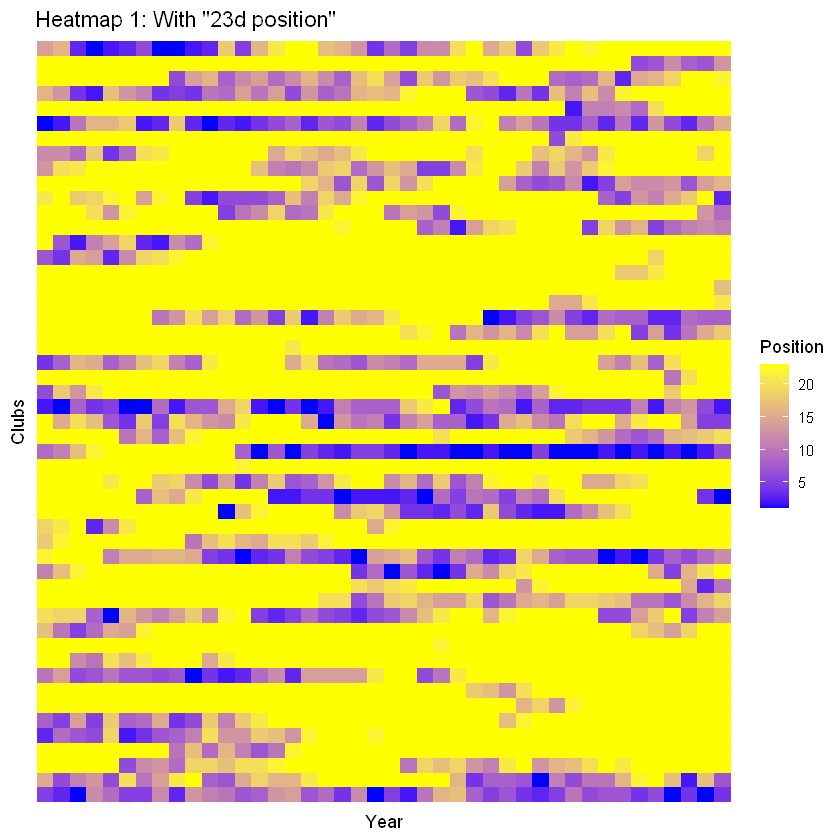

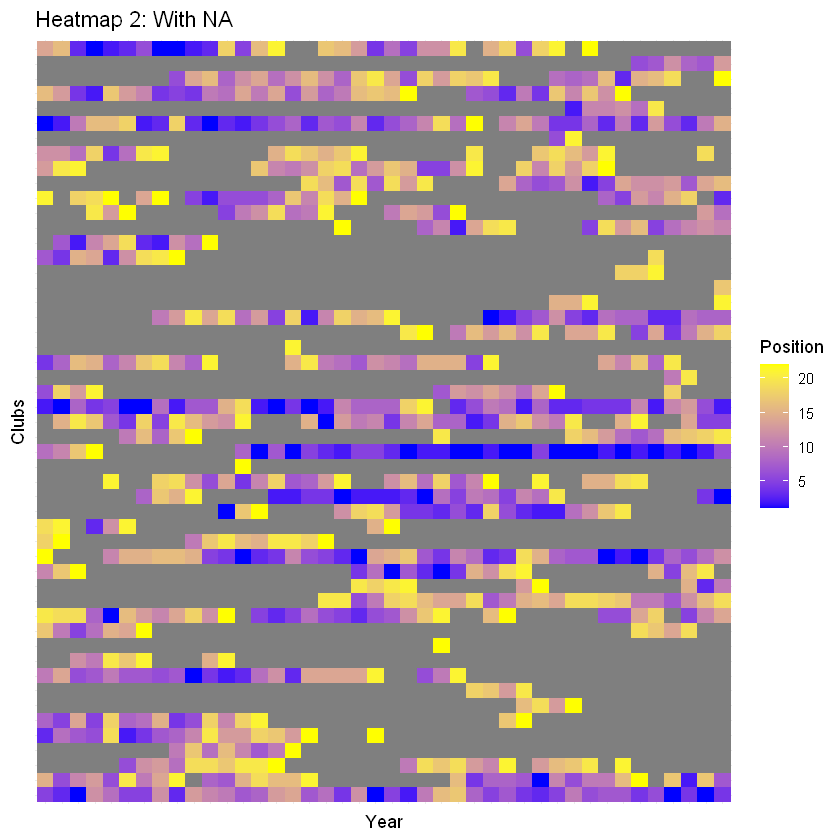

In [2]:
# Creating one data frame with NAs and one with position 23 for out-of-league teams
df_full_NA <- df_full
df_full_23 <- df_full
df_full_23[is.na(df_full_23)] <- 23



# Pivoting data frames from short to long format for the heatmap
df_full_23_long <- pivot_longer(
    df_full_23,
    cols = starts_with("19"),
    names_to = "Year",
    values_to = "Position"
)


df_full_NA_long <- pivot_longer(
    df_full_NA,
    cols = starts_with("19"),
    names_to = "Year",
    values_to = "Position"
)


ggplot(df_full_23_long, aes(x = Year, y = Team, fill = Position)) +
  geom_tile() +
  labs(title = 'Heatmap 1: With "23d position"',
       x = "Year",
       y = "Clubs")+
scale_fill_gradient(
    low = "blue",      
    high = "yellow")+
theme_minimal() +
  theme(
    axis.text.x = element_blank(),  # The text for the y-axis and x-axis
    axis.text.y = element_blank(),  # caused too much clutter, so they were removed
    axis.ticks.x = element_blank(), 
    axis.ticks.y = element_blank() 
  )


ggplot(df_full_NA_long, aes(x = Year, y = Team, fill = Position)) +
  geom_tile() +
  labs(title = "Heatmap 2: With NA",
       x = "Year",
       y = "Clubs")+
scale_fill_gradient(
    low = "blue",      
    high = "yellow")+
theme_minimal() +
  theme(
    axis.text.x = element_blank(),  
    axis.text.y = element_blank(),  
    axis.ticks.x = element_blank(),
    axis.ticks.y = element_blank()  
  )

Heatmap 1 and 2 shows how the positions of teams in the league have changed over the years. The x-axis shows the years (1951 to 1992) and the y-axis shows the different the clubs. The names of the teams and the years were not of a particular interest and cluttered the figures, so they were removed. A good performance in the league means a high position in the table (positions 1,2,3 etc) and is marked by a deep blue colour on the heatmap. A bad performance (position 22,21,20 etc) is marked with a yellow. In heatmap 1 we have added a 23rd position for teams outside of the league that year. In heatmap 2 however these values are left as NAs and are hence marked with grey.

The claim that we investigate is if every team had a genuine chance of winning the league. Our heatmaps however show that this is a doubtful claim. In heatmap 1 we can see that there are a few select horizontal lines with lots of dark blue in them, quite a number of horizontal lines with colours ranging from deep purple to pinkish yellow, and a few horizontal lines with lots of strong yellow. In other words, even as early as in the 1950s was the Football League divided into  top table, mid table, and relegation zone teams. 

As a sidenote: In heatmap 2 the teams outside of the top division of english football are clearly marked out with grey, and if we study these for a moment we see something quite interesting. If we look at the performances of a team right before they got relegated from the Football League they were often quite poor (very yellow squares) - which is reasonable. However if we look at the performances the first season they got promoted to the top English leagues those performances were often quite good. Rarely did the newly promoted team win the league, but they often placed higher than one would first guess they would (and then dropped in performance the following years). This pattern is one that many people have claimed to be true. People often reason that a newcomer to the league placed very well in the second division the prior year (top 3) and is coming to the first division with momentum, confidence and an underdog mentality which is a recipe for success. It is quite interesting to see that the claim that they often perform very well for their first one or two seasons upon promotion might actually have some substance to it. 

### Yearly cummulative table changes 

The heatmap showed that the claim that really any team could win the Football League was a dubious one at best. However, the heatmap has several flaws. The heatmap reveals all of the data and is quite overwhelming to anyone with a normal brain. It is also quite difficult to use it to pick out more subtle trends. From the heatmap one could reasonably reject the idea that literally every team had a chance of winning the league, but perhaps more (but not all) teams had genuine chance in the 1950s compared to say in the 1980s? To investigate this we need some statistical summary that is easier to comprehend. After some tinkering and playing around we end up with the follow ad-hoc method:

First consider the absolute value of the differences in table placements in two consecutive years, say between seasons 1950/1951 and 1951/1952:

In [3]:
df_full_23[, 2:43] <- lapply(df_full_23[, 2:43], as.numeric)

abs(df_full_23[,2]-df_full_23[,3])

1951
<dbl>
1
1
6
4
2
12
3
3
2


This vector contains all the changes in table positions between two seasons. The sum of all of these changes become a measure of how much change there was in table positions between two years. Some things to note: (a) we have given teams outide of the Football League a position 23 in the table, and if the team stayed at position 23 for both years (i.e. did not play in the Football League at all) then the contribution to the sum is 0 (b) since we took the absolute value of all changes in positions between the two consecutive seasons we avoid cancellations amd (c) the number of participating teams was constant during the period we study.
 
By plotting these sums for the different seasons we can see if there was a lot of change between seasons during say the 1950s compared to the 1980s. 

`geom_smooth()` using formula = 'y ~ x'


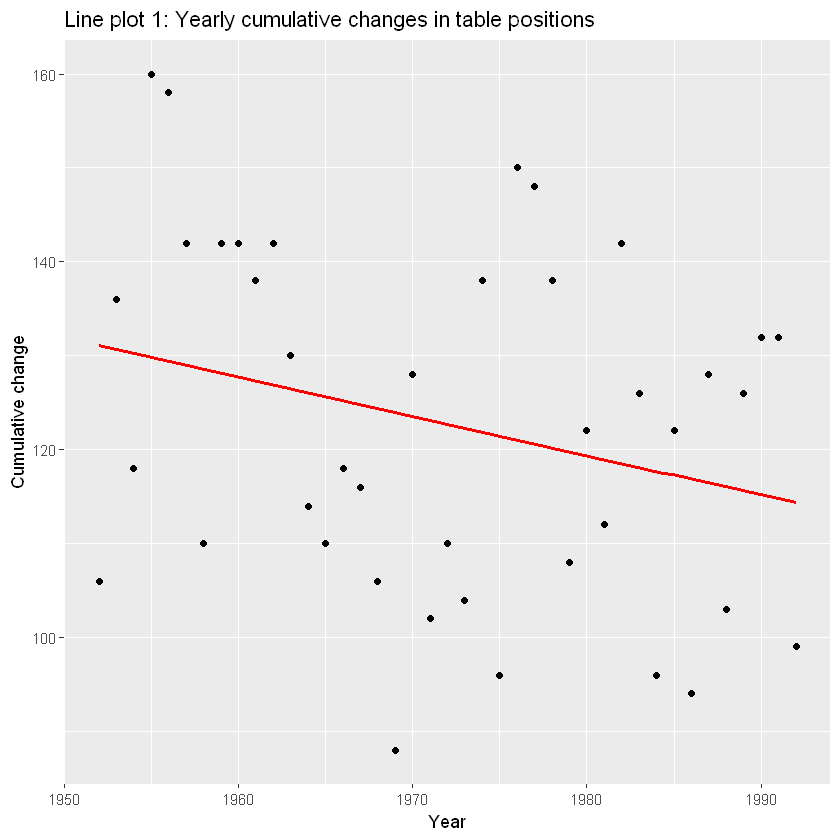

In [4]:
# Creating a data frame with all changes and years
changes <- c()
for (i in 2:42){
    increments <- abs(df_full_23[,i]-df_full_23[,i+1])
    increment_sum <- sum(increments)
    changes <- c(changes, increment_sum)
}


df_cumu_changes <- data.frame(x = 1952:1992, y = changes)


# Creating a line plot with a regression line
ggplot(df_cumu_changes, aes(x = x, y = y)) +
    geom_point() +  # Scatter plot
    geom_smooth(method = "lm", se = FALSE, color = "red") + 
    labs(title = "Line plot 1: Yearly cumulative changes in table positions", x = "Year", y = "Cumulative change")

Line plot 1 shows how the cumulative changes in positions in consecutive seasons changed over time, with the regression line picking up the general trend. The years on the x-axis mark the end of the second season. For instance: the y-value corresponding to the x-value of year 1952 is the cumulative changes in season 1951/1952 from season 1950/1951. The slope of the regression line is negative, which means that the general trend is that there was a decrease in cumulative changes in positions between two consecutives seasons. This would support the claim that the Football League got more predictable with time. However there are a few things to note first. In order to use the regression line to say that the predictability has increased with time one would reasonable first have to use a regression model and (a) verify that model assumptions are satisfied and (b) perform a statistical test for the hypothesis that the slope of the (theoretical) regression line being non-negative. As we can see from Line plot 1 there is a lot of variance in our data, so we would likely not be able to reject the null hypothesis. Regardless, statistical significance does not imply practical relevance. A drop in say 10 in the cumulative position changes might not be practically meaningful when we have 22 different teams competing in the league. Is it really a change you could sense "in real life" so to speak?

### Regional representation

Another common complaint is that the top division in English football nowadays is really more a "top division of London and the greater Manchester area". Whilst we do not know if City, United, Chelsea, Liverpool or Arsenal will win but we for sure know that it won't be Colchester United from Essex. But has this also ever not been the case? England is divided nine major regions (see https://polimapper.co.uk/guides-white-papers/other-administrative-and-statistical-geographies/uk-regions-map/) and one might wonder if there has ever been a period when each region in England actually had a legitimate presence in the Football League. Using data from https://footballgroundguide.com/news/football-clubs-near-me we can assign to each club the region they represent and do a line plot for how many clubs each region were represented by each year. 

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


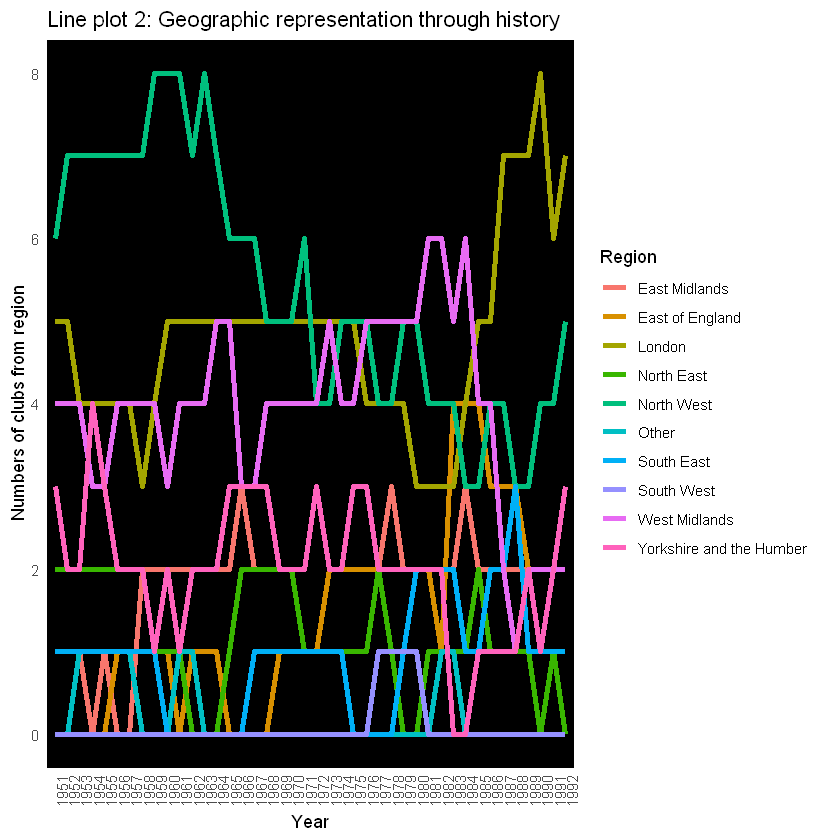

In [5]:
# Assigning each team a region. Most of the teams were copy-pasted directly from the lists on
# footballgroundguide and some clubs were added manually. Since it wasn't that much data I found it quicker 
# to just copy paste instead of scraping it

SEA <- c("Brighton and Hove Albion",
"Southampton",
"Oxford United",
"Portsmouth",
"Reading",
"Wycombe Wanderers",
"Crawley Town",
"Gillingham",
"MK Dons",
"Aldershot Town",
"Dorking Wanderers",
"Eastleigh",
"Ebbsfleet United",
"Maidenhead United",
"Oxford City",
"Woking",
"Brighton & Hove Albion")

LDN <- c("Arsenal",
"Brentford",
"Chelsea",
"Crystal Palace",
"Fulham",
"Tottenham Hotspur",
"West Ham United",
"Millwall",
"Queens Park Rangers",
"Charlton Athletic",
"Leyton Orient",
"AFC Wimbledon",
"Sutton United",
"Barnet",
"Bromley",
"Dagenham and Redbridge",
"Wealdstone",
"Wimbledon")

NOW <- c("Burnley",
"Everton",
"Liverpool",
"Manchester City",
"Manchester United",
"Blackburn Rovers",
"Preston North End",
"Blackpool",
"Bolton Wanderers",
"Carlisle United",
"Fleetwood Town",
"Wigan Athletic",
"Accrington Stanley",
"Barrow",
"Crewe Alexandra",
"Morecambe",
"Salford City",
"Stockport County",
"Tranmere Rovers",
"Altrincham",
"Fylde",
"Oldham Athletic",
"Rochdale")

EAST <- c("Luton Town",
"Ipswich Town",
"Norwich City",
"Watford",
"Cambridge United",
"Peterborough",
"Stevenage",
"Colchester United",
"Boreham Wood",
"Southend United")

WMD <- c("Aston Villa",
"Wolverhampton Wanderers",
"Birmingham City",
"Coventry City",
"Stoke City",
"West Bromwich Albion",
"Burton Albion",
"Port Vale",
"Shrewsbury Town",
"Walsall",
"Kidderminster Harriers",
"Solihull Moors")

SWE <- c("Bournemouth",
"Bristol City",
"Plymouth Argyle",
"Bristol Rovers",
"Cheltenham Town",
"Exeter City",
"Swindon Town",
"Forest Green Rovers")

YOH <- c("Sheffield United",
"Huddersfield",
"Hull City",
"Leeds United",
"Rotherham",
"Sheffield Wednesday",
"Barnsley",
"Lincoln City",
"Bradford City",
"Doncaster Rovers",
"Grimsby Town",
"Harrogate Town",
"Halifax Town",
"York City",
"Huddersfield Town",
"Middlesbrough")

EMD <- c("Nottingham Forest",
"Leicester City",
"Derby County",
"Northampton Town",
"Mansfield Town",
"Notts County",
"Chesterfield")

NEA <- c("Newcastle United",
"Middlesborough",
"Sunderland",
"Gateshead",
"Hartlepool")

# Adding regions to teams
df_full_23 <- df_full_23 %>%
  mutate(Region = case_when(
    Team %in% SEA ~ "South East",
    Team %in% LDN ~ "London",
    Team %in% NOW ~ "North West",
    Team %in% EAST ~ "East of England",
    Team %in% SWE ~ "South West",
    Team %in% YOH ~ "Yorkshire and the Humber",
    Team %in% EMD ~ "East Midlands",
    Team %in% NEA ~ "North East",
    Team %in% WMD ~ "West Midlands", 
    TRUE ~ "Other"  # Teams not found in any of the English regions (Welsh teams playing in English football)
  ))



# Pivoting from wide format to long format
df_long <- df_full_23 %>%
  pivot_longer(cols = starts_with("19"), 
               names_to = "year", 
               values_to = "points")


# Group by region and calculate region representation
df_summary <- df_long %>%
  group_by(Region, year) %>%
  summarize(count_non_23 = sum(points != 23), .groups = "drop")



ggplot(df_summary, aes(x = year, y = count_non_23, color = Region, group = Region)) +
  geom_line(size = 1.5, linetype = "solid") +  # Increase line thickness
  labs(title = "Line plot 2: Geographic representation through history", 
       x = "Year", 
       y = "Numbers of clubs from region") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 90, hjust = 1),  # Rotate x-axis labels for readability
    panel.background = element_rect(fill = "black"),  # Set background colour black
    panel.grid = element_blank() 
  )

Line plot 2 shows the geographic representation each region has had throughout history. The "Other" category includes  Swansea city and Cardiff city. They are two Welsh teams that play in the english football system for historical reasons (Wales did not have a proper football league when those clubs were founded so they started playing English football instead). As we can see by the turquoise and yellow-brown there has been a long and stable dominance by the London and North West (United, City, Liverpool etc) area. 

## Summary 

We have investigated if we could find any statistical data to substaniate the claims that the English Football League used to be less predictable, "any team had a proper chance of winning", and if there was more geographical diversity/representation. In all cases the statistical support seemed doubtful. It seems like there has always been better teams and worse teams, and most of the teams have always come from London and the greater Manchester area. However our data was limited to post world war II, so perhaps this mythical golden age of English football that people on reddit and instagram like to reminisce about was in the 1930s?